In [1]:
from gensim.models import Word2Vec
from time import time
from itertools import product
from app_extractor import FeatureExtractor
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd


In [2]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {"use", "be", "one","go","time","think","job","work"}
stop_words.update(custom_stopwords)

In [3]:
param_grilla ={
    "vector_size":[100,200],
    "window":[2],
    "min_count":[1],
    "workers":[6],
    "sg":[1],
    "negative":[30],
    "min_alpha":[0.00005],
    "seed":[42],
    "alpha": [0.0005]  
}
param_combinatios = list(product(*param_grilla.values()))
best_model = None
best_params = None
best_score = float('-inf')

In [4]:
corpus_train= pd.read_csv('./datasets/train_dataset.csv')
corpus_test= pd.read_csv('./datasets/test_dataset.csv')
corpus = pd.concat([corpus_train, corpus_test], ignore_index=True) 
feauresExt = FeatureExtractor(corpus['reviewText'],stop_words)
tokenized_corpus=feauresExt.tokenized_corpus

In [5]:
for params in param_combinatios:
    param_dict=dict(zip(param_grilla.keys(),params))
    print(f"Entrenando con parámetros: {param_dict}")
    model = Word2Vec(**param_dict)
    model.build_vocab(tokenized_corpus,progress_per=10000)
    print('Vocabulario compuesto por {} palabras'.format(len(model.wv.key_to_index)))
    t = time()
    model.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=35, report_delay=1)
    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
    vocab = list(model.wv.index_to_key)
    if len(vocab) >= 10:
        random.seed(42)
        random_words = random.sample(vocab, 10)
    else:
        random_words = vocab    
    try:
        similarity_score = sum(model.wv.similarity(w1, w2) for w1, w2 in zip(random_words, random_words[1:])) / (len(random_words)-1)
    except KeyError:
        similarity_score = float('-inf')
    print(f"  - Score: {similarity_score}\n")
    
    if similarity_score > best_score:
        best_score = similarity_score
        best_model = model
        best_params = param_dict
print(f"Mejor configuración encontrada: {best_params}")
print(f"Mejor Similarity: {best_score}")
with open(f"./model/best_word2new_{best_score:.4f}.pkl", "wb") as f:
    pickle.dump(best_model, f)
        

Entrenando con parámetros: {'vector_size': 100, 'window': 2, 'min_count': 1, 'workers': 6, 'sg': 1, 'negative': 30, 'min_alpha': 5e-05, 'seed': 42, 'alpha': 0.0005}
Vocabulario compuesto por 158264 palabras
Time to train the model: 26.61 mins
  - Score: 0.9042973783281114

Entrenando con parámetros: {'vector_size': 200, 'window': 2, 'min_count': 1, 'workers': 6, 'sg': 1, 'negative': 30, 'min_alpha': 5e-05, 'seed': 42, 'alpha': 0.0005}
Vocabulario compuesto por 158264 palabras
Time to train the model: 31.48 mins
  - Score: 0.9097314476966858

Mejor configuración encontrada: {'vector_size': 200, 'window': 2, 'min_count': 1, 'workers': 6, 'sg': 1, 'negative': 30, 'min_alpha': 5e-05, 'seed': 42, 'alpha': 0.0005}
Mejor Similarity: 0.9097314476966858


In [6]:
from nltk import FreqDist
import itertools

all_tokens = list(itertools.chain.from_iterable(tokenized_corpus))
freq_dist = FreqDist(all_tokens)
most_common_words = freq_dist.most_common(6)
for word, freq in most_common_words:
    print(f"{word}: {freq}")

not: 348504
good: 110223
great: 102727
like: 100349
just: 93207
buy: 79978


In [7]:
target_words= {words for words, freq in most_common_words[1:]}

In [5]:
target_words={'not', 'good', 'great', 'like', 'just','buy'}

In [9]:
top_n = 10
words = []
vectors = []
with open('./model/best_word2new_0.9097.pkl', 'rb') as f:
     smodel = pickle.load(f)

In [13]:
words = set()  
vectors = []

for word in target_words:
    if word in smodel.wv and word not in words:
        words.add(word)
        vectors.append(smodel.wv[word]) 
       
        similar_words = smodel.wv.most_similar(word, topn=top_n * 2)  
        unique_words = []  
        
        for w, _ in similar_words:
            if w not in words: 
                unique_words.append(w)
            if len(unique_words) == top_n: 
                break

        for sim_word in unique_words:
            words.add(sim_word)
            vectors.append(smodel.wv[sim_word])


words = list(words)

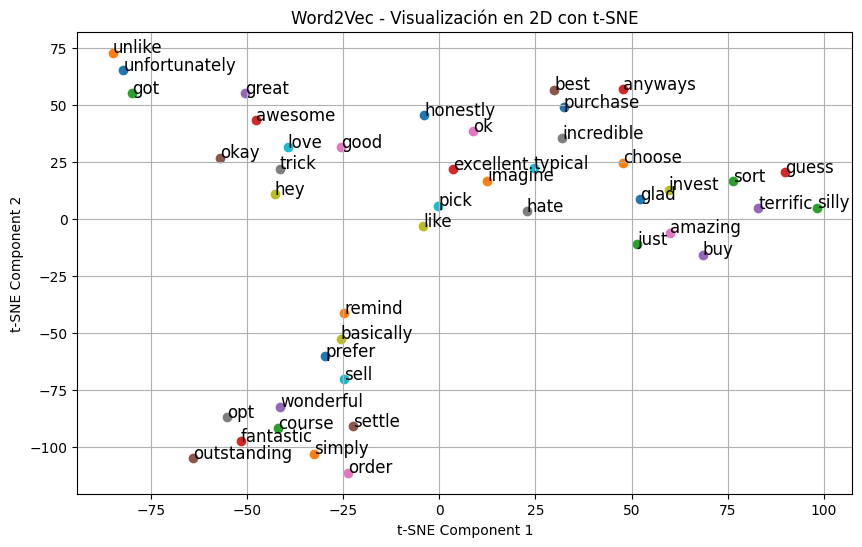

In [12]:
vectors = np.array(vectors)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_vectors = tsne.fit_transform(vectors)


plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    x, y = reduced_vectors[i]
    plt.scatter(x, y, marker="o")
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.title("Word2Vec - Visualización en 2D con t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

In [21]:
smodel.wv.most_similar(positive=["good"])

[('great', 0.9374164342880249),
 ('decent', 0.9372572898864746),
 ('excellent', 0.9249477386474609),
 ('fantastic', 0.9200424551963806),
 ('best', 0.9099454283714294),
 ('okay', 0.905701756477356),
 ('terrific', 0.9046726226806641),
 ('ok', 0.904238760471344),
 ('incredible', 0.9008439183235168),
 ('wonderful', 0.8994309902191162)]

In [22]:
smodel.wv.most_similar(positive=["hate"])

[('anymore', 0.9556823372840881),
 ('lol', 0.9437811970710754),
 ('stupid', 0.9425736665725708),
 ('bother', 0.9422262907028198),
 ('oh', 0.9394248723983765),
 ('freak', 0.9386661648750305),
 ('hey', 0.9378083944320679),
 ('wonder', 0.9358352422714233),
 ('seriously', 0.9352988004684448),
 ('honestly', 0.9350637197494507)]

In [23]:
smodel.wv.most_similar(positive=["not"])

[('do not', 0.9095103144645691),
 ('anymore', 0.8988786339759827),
 ('possibly', 0.8947947025299072),
 ('honestly', 0.8896386623382568),
 ('heck', 0.887464702129364),
 ('obviously', 0.8872157335281372),
 ('mean', 0.8866106867790222),
 ('though', 0.883849024772644),
 ('rarely', 0.8810197114944458),
 ('necessarily', 0.8808907270431519)]

##### Análisis del Modelo Word2Vec  

Se entrenó un modelo **Word2Vec** para capturar relaciones semánticas entre palabras a partir de las reseñas procesadas.  
A continuación, se muestran algunos resultados obtenidos al analizar la similitud entre palabras clave:  

📌 **Palabras similares a "good"**  
El modelo identificó términos altamente relacionados con **"good"**, como `great`, `excellent`, `fantastic`, `best`, e `incredible`, lo que indica que ha aprendido correctamente asociaciones con adjetivos positivos.  

📌 **Palabras similares a "not"**  
El modelo asoció **"not"** con expresiones como `do not`, `anymore`, `possibly`, y `rarely`, reflejando un aprendizaje adecuado de negaciones y términos que suelen acompañarlas.  

📌 **Palabras similares a "hate"**  
En el caso de **"hate"**, el modelo encontró palabras como `stupid`, `bother`, y `seriously`, lo que sugiere que ha capturado términos con carga negativa y emociones fuertes.  

🔹 **Conclusión:**  
El modelo **Word2Vec** entrenado logra capturar con precisión las relaciones semánticas en el conjunto de datos, lo que es clave para tareas de análisis de sentimientos y clasificación de texto. 🚀  